## **Final Project: Predicting Telecom Customer Churn**

Notebook Run Time: ~ 25min

**Background**: Telecom operator Interconnect would like to be able to forecast the churn of their clients. If the customer is likely to leave, they will be sent promotions and special plan offers.  

**Purpose**: Fit an imbalanced classification model that accurately predicts which customers are likely to leave the company.  

**Techniques**: CatBoost, LGBM, XGBoost, AdaBoost, pipelines, GridSearchCV, class balancing.  

**Sections**:  
* [Import Data](#import)  
* [Prepare Data](#prepare)  
* [Exploratory Analysis](#explore)  
* [Train Models (Logistic Regression and Gradient Boosting)](#train)  
* [Test Best Model](#test)  
* [Conclusions and Business Application](#conclude)

### **Import Packages and Data**<a id='import'></a>

In [118]:
import time
notebook_start = time.time()

In [119]:
#Import Packages
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier, plot_importance

from xgboost import XGBClassifier

In [120]:
# Set styles
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 25)

sns.set_style('whitegrid')

In [121]:
# User-defined GridSearchCV results function
def gscv_results(gscv_object, main_scorer, *add_scores):
    '''Take an sklearn GridSearchCV object and return best model parameters and a 
    pandas dataframe of the main score and specified scorers for the best model.
    
    gscv_object: fitted GridSearchCV object with one or multiple scorers.
    main_scorer: scorer passed to gscv_object, or refit score if gscv_object has multiple scorers.
    add_scores: list of additional score names passed to gscv_object.'''
    cv_results = pd.DataFrame(gscv_object.cv_results_).sort_values(by=f'mean_test_{main_scorer}', ascending=False)

    best_params = gscv_object.best_params_
    best_index = gscv_object.best_index_

    # create data frame with best main score
    best_score = gscv_object.best_score_.round(4)
    results = pd.DataFrame(data={f'{main_scorer}':[best_score]})
    
    # for score in additional scores, add column with score
    for score in add_scores:
        results[f'{score}'] = cv_results.loc[best_index, f'mean_test_{score}'].round(4)

    return best_params, results

In [122]:
# User-defined cross_validate results function
def cv_results(cv_object, main_scorer, *add_scores):
    '''Take a sklearn cross_validate object and return a pandas dataframe of 
    the average main score and average of any additional scores across cross 
    validated trials.
    
    cv_object: fitted cross_validate object with one or multiple scorers.
    main_scorer: scorer passed to cross_validate object, or refit score if cross_validate
                 has multiple scorers.
    add_scores: list of additional score names passed to cv_object.'''
     # create data frame with best main score
    main_scorer_avg = cv_object[f'test_{main_scorer}'].mean()
    results = pd.DataFrame(data={f'{main_scorer}': [main_scorer_avg]})
    
    # for score in additional scores, calculate average and add column with score
    for score in add_scores:
        score_avg = cv_object[f'test_{score}'].mean()
        results[f'{score}'] = score_avg
    
    return results

In [123]:
# Read in dataframes
try:
    contract_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/contract.csv', parse_dates=True)
    internet_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/internet.csv', parse_dates=True)
    personal_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/personal.csv', parse_dates=True)
    phone_df = pd.read_csv('/Users/kellyshreeve/Desktop/Data-Sets/Final Project/final_provider/phone.csv', parse_dates=True)
except:
    contract_df = pd.read_csv('/datasets/final_provider/contract.csv', parse_dates=True)
    internet_df = pd.read_csv('/datasets/final_provider/internet.csv', parse_dates=True)
    personal_df = pd.read_csv('/datasets/final_provider/personal.csv', parse_dates=True)
    phone_df = pd.read_csv('/datasets/final_provider/phone.csv', parse_dates=True)

In [124]:
# Print df info
print('Contract DF')
print()
print(contract_df.info())
print()

contract_df.head()

Contract DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [125]:
print('Internet DF')
print()
print(internet_df.info())
print()

internet_df.head()

Internet DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [126]:
print('Personal DF')
print() 
print(personal_df.info())
print()

personal_df.head()

Personal DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [127]:
print('Phone DF')
print()
print(phone_df.info())
print()

phone_df.head()

Phone DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


##### Initial Data Observations

* There are total four datasets  
    - *contract_df*: Customer plan start and payment plan  
    - *internet_df*: Internet plan subscription and extra services  
    - *personal_df*: Demographics  
    - *phone_df*: Phone subscription type  
* Datasets represent 7043 total customers  
* Key is customerID

### **Prepare Data**<a id='prepare'></a>

Data columns are re-named, and data is explored for missing values and duplicates. The four dataframes are outer-merged. Customers who do not have an internet or phone plan are filled with 'no_plan'. Feature creation.

#### Convert Column Names to Snake Case

In [128]:
# Convert column names to snake case
contract_df.columns = (contract_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

internet_df.columns = (internet_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

personal_df.columns = (personal_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

phone_df.columns = (phone_df.columns
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)
                       .str.lower())

print('Contract Columns:')
for column in contract_df.columns:
    print(column)
print()

print('Internet Columns:')
for column in internet_df.columns:
    print(column)
print()

print('Personal Columns:')
for columnn in personal_df.columns:
    print(column)
print()

print('Phone Columns:')
for column in phone_df.columns:
    print(column)

Contract Columns:
customer_i_d
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges

Internet Columns:
customer_i_d
internet_service
online_security
online_backup
device_protection
tech_support
streaming_t_v
streaming_movies

Personal Columns:
streaming_movies
streaming_movies
streaming_movies
streaming_movies
streaming_movies

Phone Columns:
customer_i_d
multiple_lines


* All column names look good except 'customer_i_d' and 'steraming_t_v'.
* Fix these two column names below.

In [129]:
# Fix Customer ID and Streaming TV column names
contract_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)
internet_df.rename(columns={'customer_i_d':'customer_id', 'streaming_t_v':'streaming_tv'}, 
                   errors='raise', inplace=True)
personal_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)
phone_df.rename(columns={'customer_i_d':'customer_id'}, errors='raise', inplace=True)

print('Contract Columns:')
for column in contract_df.columns:
    print(column)
print()

print('Internet Columns:')
for column in internet_df.columns:
    print(column)
print()

print('Personal Columns:')
for column in personal_df.columns:
    print(column)
print()

print('Phone Columns:')
for column in phone_df.columns:
    print(column)

Contract Columns:
customer_id
begin_date
end_date
type
paperless_billing
payment_method
monthly_charges
total_charges

Internet Columns:
customer_id
internet_service
online_security
online_backup
device_protection
tech_support
streaming_tv
streaming_movies

Personal Columns:
customer_id
gender
senior_citizen
partner
dependents

Phone Columns:
customer_id
multiple_lines


* All column names are successfully converted to snake case.

#### Check for Missing Values

We already know there are no np.nan missing values in the dataframes. Frequency tables of each variable are displayed to determine whether missing values have been marked with other words or symbols.

##### Contract DF Missing

In [130]:
# Categorical columns
categorical_columns = ['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method']

for column in categorical_columns:
    display(contract_df[column].value_counts().reset_index())
    print()

,begin_date,count
0,2014-02-01,366
1,2019-10-01,237
2,2019-11-01,237
3,2019-09-01,237
4,2020-01-01,233
5,2019-12-01,220
6,2014-03-01,178
7,2019-07-01,156
8,2019-08-01,146
9,2019-06-01,141


,end_date,count
0,No,5174
1,2019-11-01 00:00:00,485
2,2019-12-01 00:00:00,466
3,2020-01-01 00:00:00,460
4,2019-10-01 00:00:00,458


,type,count
0,Month-to-month,3875
1,Two year,1695
2,One year,1473


,paperless_billing,count
0,Yes,4171
1,No,2872


,payment_method,count
0,Electronic check,2365
1,Mailed check,1612
2,Bank transfer (automatic),1544
3,Credit card (automatic),1522


* No implicit missing values in the contract df categorical columns.

In [131]:
# Numeric Columns
numeric_columns = ['monthly_charges', 'total_charges']

for column in numeric_columns:
    print(column)
    display(contract_df[column].value_counts().reset_index().sort_values(by=column, ascending=False).reset_index(drop=True))
    print()

monthly_charges


,monthly_charges,count
0,118.75,1
1,118.65,1
2,118.60,2
3,118.35,1
4,118.20,1
...,...,...
1580,18.75,1
1581,18.70,2
1582,18.55,1
1583,18.40,1



total_charges


,total_charges,count
0,999.9,1
1,999.8,1
2,999.45,1
3,998.1,1
4,997.75,1
...,...,...
6526,100.4,1
6527,100.35,1
6528,100.25,1
6529,100.2,1


* Total charges does have an implicit missing value marked as an empty space in the dataframe.

Fill missing value in total charges with np.nan

In [132]:
contract_df['total_charges'] = contract_df['total_charges'].replace(' ', np.nan)

# Fill missing with median of total charges
contract_df['total_charges'] = contract_df['total_charges'].fillna(contract_df['total_charges'].median())

contract_df['total_charges'] = pd.to_numeric(contract_df['total_charges'])

display(contract_df['total_charges'].value_counts().reset_index().sort_values(by='total_charges'))

,total_charges,count
3898,18.80,1
187,18.85,2
927,18.90,1
4965,19.00,1
3903,19.05,1
...,...,...
5896,8564.75,1
2960,8594.40,1
2523,8670.10,1
589,8672.45,1


In [133]:
# Check spaces have been filled with np.nan
print('Total Charges Missing:')
display(contract_df['total_charges'].isna().sum())

Total Charges Missing:


0

* Missing values have been replaced with np.nan. The number of missing values is equal to the number of spaces in the original variable.
* This is such a small number of missing values, these observations will be dropped from the analysis.

##### Internet DF Missing

In [134]:
# Check for implicit missing values
categorical_columns = ['internet_service', 'online_security', 'online_backup', 'device_protection', 
                       'tech_support', 'streaming_tv', 'streaming_movies']

for column in categorical_columns:
    display(internet_df[column].value_counts().reset_index())
    print()

,internet_service,count
0,Fiber optic,3096
1,DSL,2421


,online_security,count
0,No,3498
1,Yes,2019


,online_backup,count
0,No,3088
1,Yes,2429


,device_protection,count
0,No,3095
1,Yes,2422


,tech_support,count
0,No,3473
1,Yes,2044


,streaming_tv,count
0,No,2810
1,Yes,2707


,streaming_movies,count
0,No,2785
1,Yes,2732


* There are no implicit missing values in the internet dataframe.

##### Personal DF Missing

In [135]:
# Check for implicit missing values
categorical_columns = ['gender', 'senior_citizen', 'partner', 'dependents']

for column in categorical_columns:
    display(personal_df[column].value_counts().reset_index())

,gender,count
0,Male,3555
1,Female,3488


,senior_citizen,count
0,0,5901
1,1,1142


,partner,count
0,No,3641
1,Yes,3402


,dependents,count
0,No,4933
1,Yes,2110


* There are  no implicit missing values in the personal dataframe.

##### Phone DF Missing

In [136]:
# Check for implicit duplicates
display(phone_df['multiple_lines'].value_counts().reset_index())

,multiple_lines,count
0,No,3390
1,Yes,2971


* There are no implicit missing values in the phone dataframe.  

* All columns in all datasets have been explored for implicit missing values. 'Total_charges' is the only column with an implicit missing value; there are no implicit missing values in any other column.

#### Duplicates

##### Check for full duplicates

In [137]:
print('Contract DF Duplicates:')
print(contract_df.duplicated().sum())
print()

print('Internet DF Duplicates:')
print(internet_df.duplicated().sum())
print()

print('Personal DF Duplicates:')
print(personal_df.duplicated().sum())
print()

print('Phone DF Duplicates:')
print(phone_df.duplicated().sum())

Contract DF Duplicates:
0

Internet DF Duplicates:
0

Personal DF Duplicates:
0

Phone DF Duplicates:
0


* There are no full duplicates in any dataframe.

##### Check for implicit duplicate of customer ids

In [138]:
print('Contract DF Customer ID Duplicates:')
print(contract_df['customer_id'].duplicated().sum())
print()

print('Internet DF Customer ID Duplicates:')
print(internet_df['customer_id'].duplicated().sum())
print()

print('Personal DF Customer ID Duplicates:')
print(personal_df['customer_id'].duplicated().sum())
print()

print('Phone DF Customer ID Duplicates:')
print(phone_df['customer_id'].duplicated().sum())

Contract DF Customer ID Duplicates:
0

Internet DF Customer ID Duplicates:
0

Personal DF Customer ID Duplicates:
0

Phone DF Customer ID Duplicates:
0


* There are no duplicate customer IDs in any dataframe.
* I do not have concerns about duplication in this dataset.

#### Fix Data Types

The contract dataframe is the only dataframe with incorrect data types. 

##### Change begin date to datetime and total charges to float

In [139]:
print('Contract DF Original Data Types:')
print(contract_df.info())
contract_df.head()

Contract DF Original Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [140]:
# Change begin_date to datetime
contract_df['begin_date'] = pd.to_datetime(contract_df['begin_date'], yearfirst=True)

# Change total_charges to float
contract_df['total_charges'] = contract_df['total_charges'].astype('float')

print(contract_df.info())
contract_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB
None


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


* Begin date is changed to datetime. 
* Total charges is changed to float.

#### Merge Data Frames

In [141]:
merged_df = contract_df.merge(personal_df, how='outer')
merged_df = merged_df.merge(internet_df, how='outer')
merged_df = merged_df.merge(phone_df, how='outer')

print(merged_df.info())
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


* All dataframes have been outer-merged, and new np.nan values have been created where customers do not belong to internet or phone plans.

#### Fill Missing Values from Outer Merge

Missing values from the outer merge will be filled with 'no_plan', representing customers who do not have either a phone or internet plan.

In [142]:
# Fill missing values with 'no_plan'
merged_df.iloc[: , 12:20] = merged_df.iloc[:, 12:20].fillna('no_plan')

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

* All missing values have been filled with 'no_plan'

#### Create New Features

##### Churn Feature  
1 = did churn  
0 = did not churn

In [143]:
merged_df['churned'] = np.where(merged_df['end_date'] == 'No', 0, 1)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


##### Begin Year Feature
Year of plan start date

In [144]:
merged_df['begin_year'] = merged_df['begin_date'].dt.year

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019


##### Total Internet Services Feature
Sum of Internet Service Subscriptions

In [145]:
def services_sum(row):
    '''Counts the number of internet services a customer subscribes
    to and returns the total number of services.'''
    internet_services = 0
    
    security = row['online_security'] 
    backup = row['online_backup'] 
    protection = row['device_protection']
    support = row['tech_support']
    tv = row['streaming_tv']
    movies = row['streaming_movies']
    
    services = [security, backup, protection, support, tv, movies]
    
    for service in services:
        if service == 'Yes':
            internet_services += 1
            
    return internet_services

merged_df['total_internet_services'] = merged_df.apply(services_sum, axis=1)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0


##### Has Internet Service Feature

1 = has internet  
0 = does not have internet

In [146]:
merged_df['has_internet'] = np.where(merged_df['internet_service'] == 'no_plan', 0, 1)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,has_internet
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0,1


##### Has Protection/support

1 = has online security or online backup or device protection or tech support  
0 = does not have any protections or security

In [147]:
merged_df['has_protection'] = np.where(((merged_df['online_security'] == 'Yes') |
                                        (merged_df['online_backup'] == 'Yes') |
                                        (merged_df['device_protection'] == 'Yes') |
                                        (merged_df['tech_support'] == 'Yes')), 1, 0)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,has_internet,has_protection
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1,1,1
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,2017,2,1,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,2019,2,1,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3,1,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1,2019,0,1,0


##### Has Streaming

1 = Has streaming tv or streaming movies  
0 = Does not have any streaming services

In [148]:
merged_df['has_streaming'] = np.where(((merged_df['streaming_tv'] == 'Yes') |
                                        (merged_df['streaming_movies'] == 'Yes')), 1, 0)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,has_internet,has_protection,has_streaming
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,...,Yes,No,No,No,No,no_plan,0,2020,1,1,1,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,...,No,Yes,No,No,No,No,0,2017,2,1,1,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,...,Yes,No,No,No,No,No,1,2019,2,1,1,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,...,No,Yes,Yes,No,No,no_plan,0,2016,3,1,1,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,...,No,No,No,No,No,No,1,2019,0,1,0,0


##### Contract Length Feature
Days from begin date to end_date, or if no end date, days from begin date to date of last update

In [149]:
# Create intermediate column with 'No' end date filled with last data update '2020-02-01'
merged_df['end_date_or_last_date'] = np.where(merged_df['end_date'] == 'No', '2020-02-01', merged_df['end_date'])

# Convert to date time
merged_df['end_date_or_last_date'] = pd.to_datetime(merged_df['end_date_or_last_date'], yearfirst=True, format='mixed')

# Create column with days between begin date and end date or 2020-02-01
merged_df['contract_length'] = (merged_df['end_date_or_last_date'] - merged_df['begin_date']).dt.days

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,...,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,has_internet,has_protection,has_streaming,end_date_or_last_date,contract_length
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,...,No,No,No,no_plan,0,2020,1,1,1,0,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,...,No,No,No,No,0,2017,2,1,1,0,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,...,No,No,No,No,1,2019,2,1,1,0,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,...,Yes,No,No,no_plan,0,2016,3,1,1,0,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,...,No,No,No,No,1,2019,0,1,0,0,2019-11-01,61


* Four new columns have been created, with churn, begin year, total internet services, and contract length (days).

### Prepare Data Conclusions
* Missing values have been explored and cleaned from the dataset. The implicit missing value in total charges of ' ' has been replaced with the median of total charges. There were no other missing values found.
* No duplicates were found in the four datasets.
* The four datasets have been outer-merged together. Missing values were filled with 'no_plan' to represent customers who do not have either a phone or internet service.
* Seven new features were created:  
    - *churn*: 0 = did not churn, 1 = did churn
    - *begin_year*: Year of contract start date
    - *total_internet_services*: Number of internet services a customer subscribes to
    - *has_internet_service*: 0 = no internet plan, 1 = internet plan
    - *has_protection*: 0 = no proteciton services, 1 = at least one protection service  
    - *has_streaming*: 0 = no streaming services, 1 = at least one streaming service
    - *contract_length*: Days between plan begin date and plan end date, or if a customer has not churned, days between plan begin date and last data update (2020-01-01)

## **Exploratory Analysis**<a id='explore'></a>

* Barplots and histograms, colored by churn.  
* Time series of churn by plan start date.  
* Correlations of numeric variables.

##### Bar Plot of Target - Churn

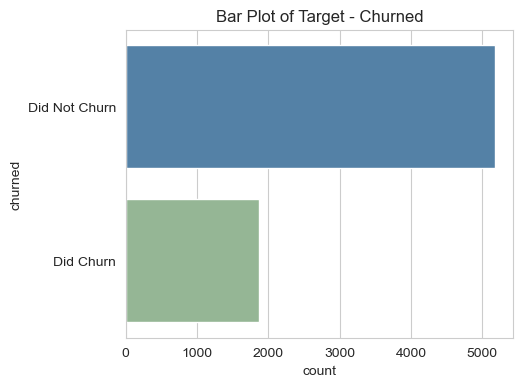

In [150]:
plt.figure(figsize=(5, 4))

sns.countplot(merged_df, y='churned', palette=['steelblue', 'darkseagreen'])

plt.title('Bar Plot of Target - Churned')
plt.yticks(ticks=[0, 1], labels=['Did Not Churn', 'Did Churn'])

plt.show()

* Almost 3 times as many customers did not churn than those who did churn.
* This is an imbalanced classification problem.

##### Bar Plots of Categorical Features by Churn

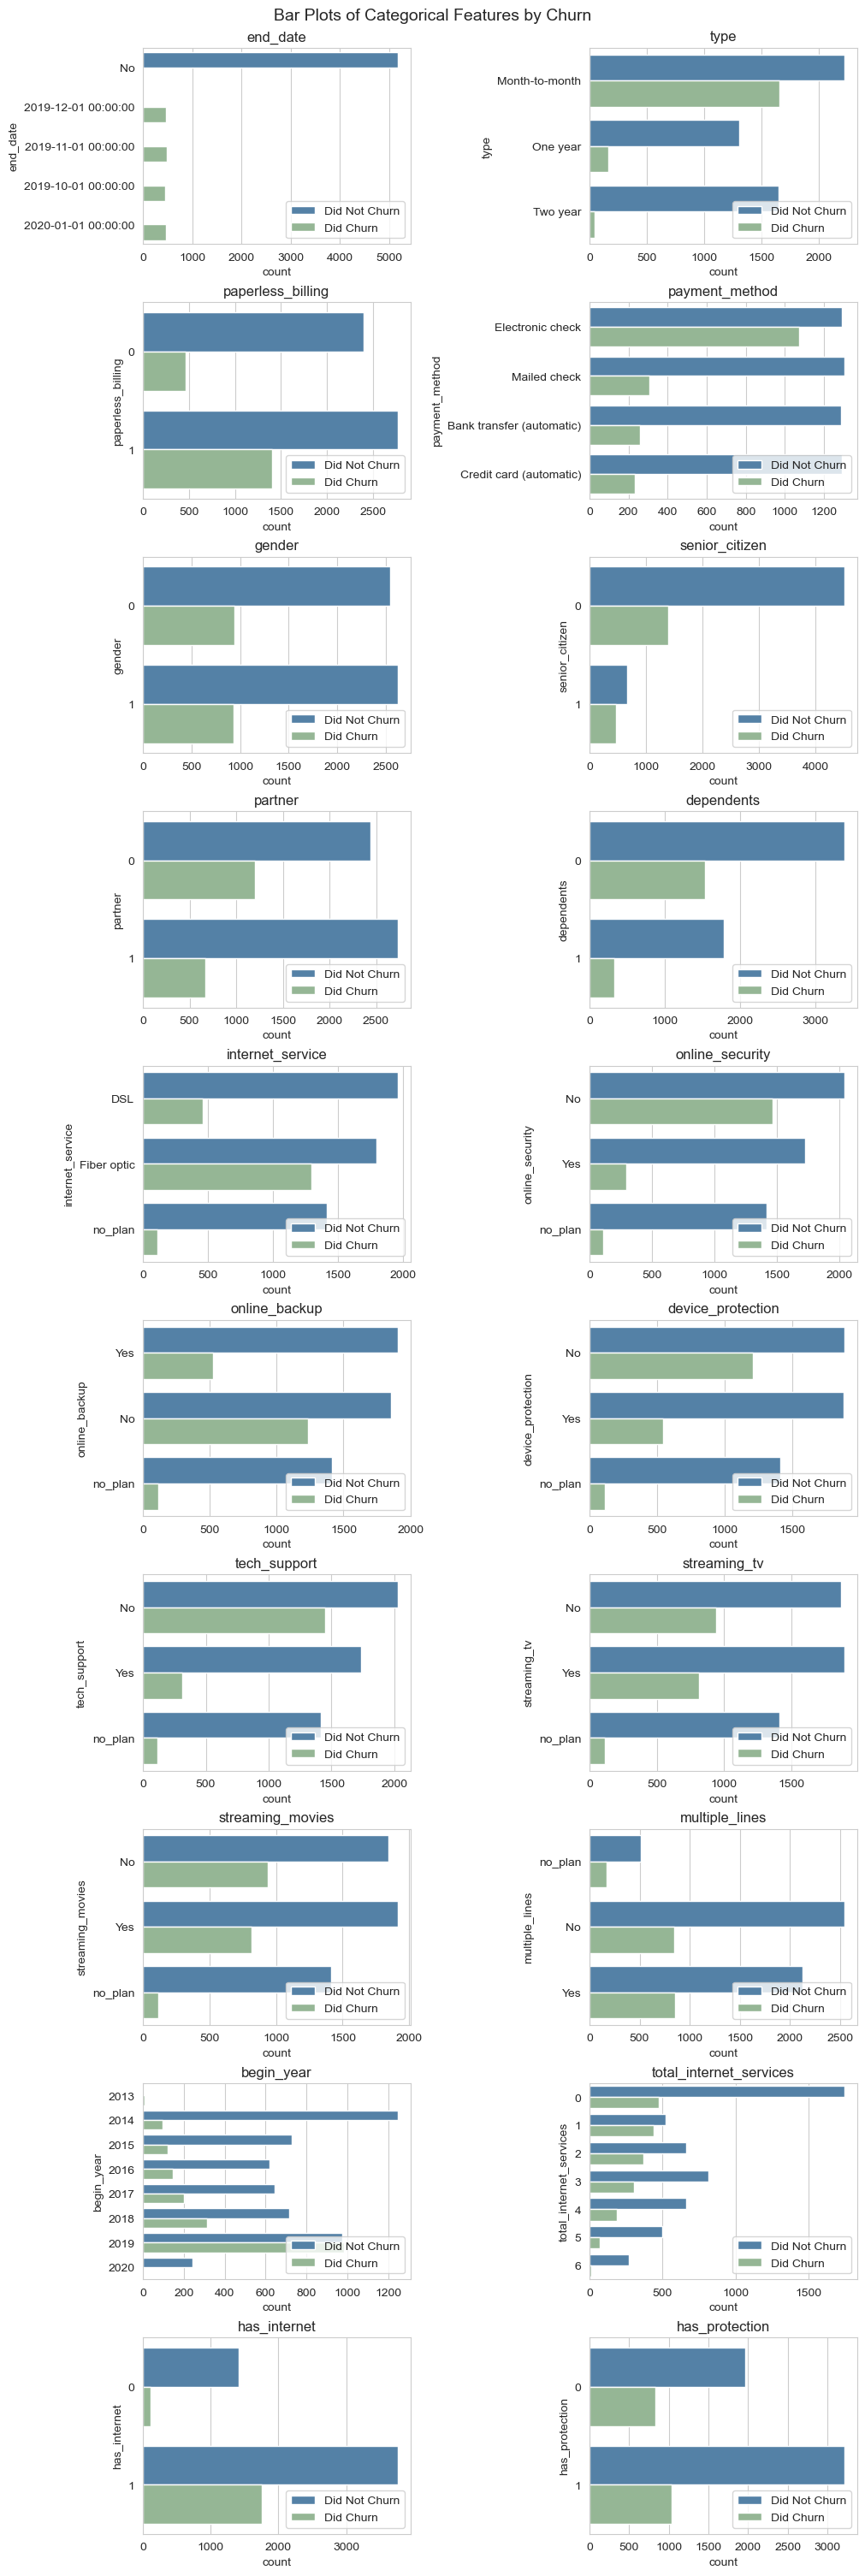

In [187]:
categorical_columns = merged_df.drop(['customer_id', 'begin_date', 'monthly_charges', 'total_charges', 
                                      'contract_length', 'end_date_or_last_date'], axis=1)

fig, axs = plt.subplots(10, 2, figsize=(10, 30), layout='constrained')
fig.suptitle("Bar Plots of Categorical Features by Churn", fontsize=14)

for column, ax in zip(categorical_columns.columns.drop('churned'), axs.ravel()):
    count_plot = sns.countplot(merged_df, 
                               y=column, 
                               hue='churned', 
                               palette=['steelblue', 'darkseagreen'], 
                               ax=ax)
    ax.set_title(f'{column}')
    ax.legend(['Did Not Churn', 'Did Churn'], loc='lower right')  
    
plt.show()

* This dataset contains customers who churned during the months of October, November, and December 2019 and January 2020.
* Most customers are month-to-month. Month-to-month customers are more likely to churn than customers with other plan types.
* Electronic Check is the most popular payment method. Customers who pay with electronic checks are more likely to churn than customers who pay with other methods.
* There are an almost equal number of males and females. The two genders are equally likely to churn.
* Most customers are not senior citizens.
* Customers who do not have extra internet services are generally more likely to churn than customers who do. Customers with 6 additional internet services are the least likely to churn.
* 2014 and 2019 are the most common plan start years. The earlier a customer joined the company, the less likely it is that they have churned.

##### Time Series of Customer Churn by Plan Start Date

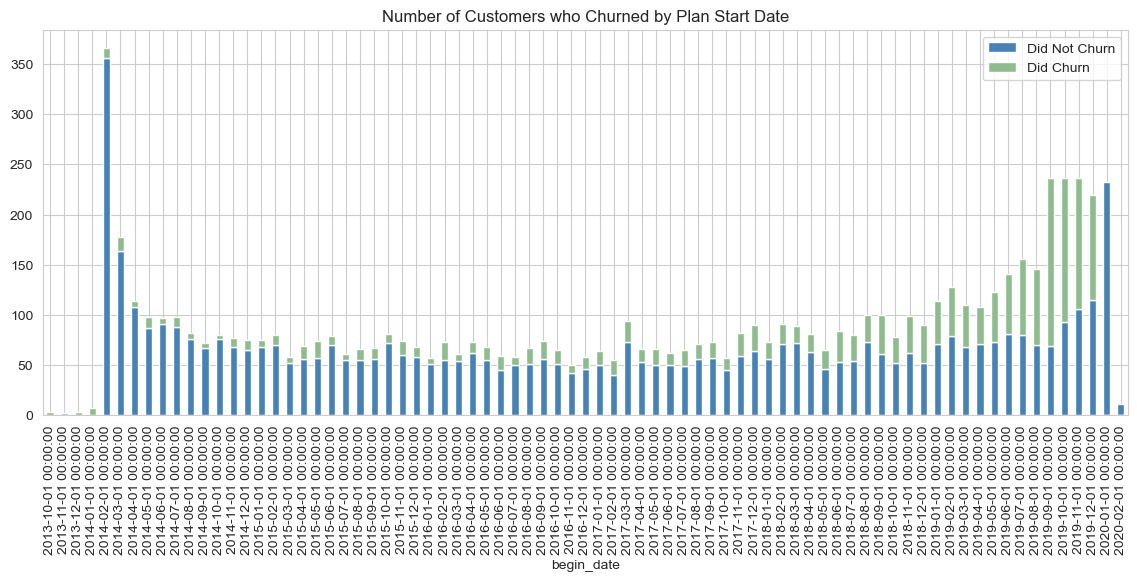

In [152]:
churned_by_date = merged_df.groupby(['begin_date', 'churned']).size().reset_index().pivot(columns='churned', index='begin_date', values=0)

churned_by_date.plot(kind='bar', 
                     stacked=True, 
                     figsize=(14, 5), 
                     color=['steelblue', 'darkseagreen'])

plt.title('Number of Customers who Churned by Plan Start Date')
plt.legend(['Did Not Churn', 'Did Churn'])

plt.show()

* Customers who began their contracts in 2014 - 2018 are almost all still with the company.
* About 50% of customers who began their contracts in 2019 - 2020 have already churned.
* New customers are more likely to leave than old customers.

##### Histograms of Continuous Features

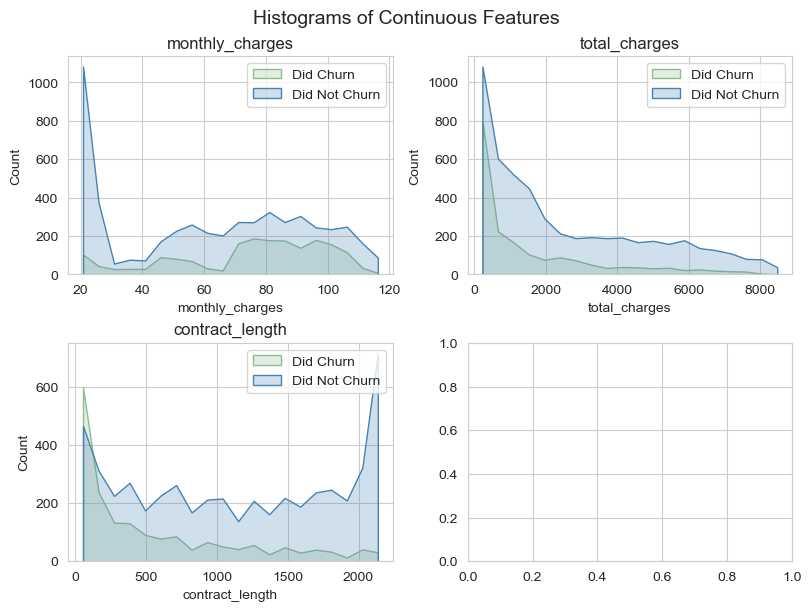

In [185]:
continuous_columns = merged_df[['monthly_charges', 'total_charges', 'contract_length']]

fig, axs = plt.subplots(2, 2, figsize=(8, 6), layout='constrained')
fig.suptitle('Histograms of Continuous Features', fontsize=14)

for column, ax in zip(continuous_columns, axs.ravel()):
    sns.histplot(merged_df, 
                 x=column, 
                 palette=['steelblue', 'darkseagreen'], 
                 bins=20, 
                 hue='churned', 
                 ax=ax, 
                 element='poly')
    ax.set_title(f'{column}')
    ax.legend(labels=['Did Churn', 'Did Not Churn']) 
    
plt.show()

* The distribution of monthly charges has three peaks at $20, $50, and $80 per month.
* Total charges is highly right skewed, with most people paying close to $0 total and only a few people paying over $6000 over the life of their plan.
* Contract length is bi-modal, with many people having contracts less than 100 months or more than 2000 months.

#### Correlations of Numeric Features

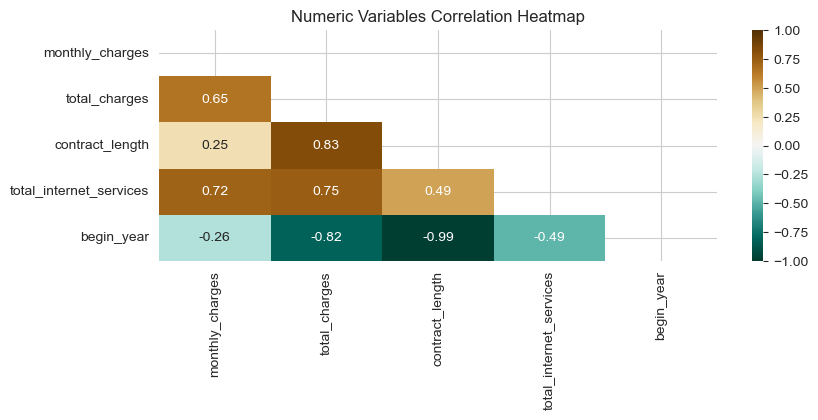

In [154]:
corr_matrix = merged_df[['monthly_charges', 'total_charges', 'contract_length', 
                         'total_internet_services', 'begin_year']].corr()
ones_triangle = np.triu(np.ones_like(corr_matrix))

plt.figure(figsize=(9, 3))
heatmap = sns.heatmap(corr_matrix, 
                      mask=ones_triangle, 
                      vmin=-1, 
                      vmax=1,
                      annot=True, 
                      cmap='BrBG_r')
heatmap.set_title('Numeric Variables Correlation Heatmap')

plt.show()

* The correlation heatmap shows high correlations between numeric features, representing multicollinearity, and a violation of the assumption of non-multicollinearity. Some features will need to be removed from the model.
* Total internet services is highly correlated with monthly charges (r = 0.72) and total charges (r = 0.75) and will be dropped from the model.
* Begin year and contract length have a very strong, negative relationship (r = -0.99). Because contract length was calculated based on an artificial end date for customers who still have contracts, begin year is a more accurate measure of customers' characteristics. Contract length will be dropped from the model.
* Total charges, while highly correlated with begin year (r = -0.82), shares only a moderate correlation with monthly charges (r = 0.65). Tree models are not highly affected by slight multicollinearity. Total charges will be kept in the model.
* Begin year and monthly charges have a low correlation with each other and will be kept in the model (r = -0.26)

##### Exploratory Analysis Conclusions

* Customers who have been with the company longer are less likely to churn. New customers are more likely to churn.  
* Customers who do not have extra internet services are generally more likely to churn than customers who do. Customers with 6 additional internet services are the least likely to churn.
* 2014 and 2019 are the most common plan start years. The earlier a customer joined the company, the less likely it is that they have churned.

## **Train Classification Models**<a id='train'></a>

**Target**:   
* *churned*: 0 = has not churned, 1 = has churned

**Features**:   
* *begin_year*: year of contract start date
* *type*: type of contract  
* *paperless_billing*: customer has paperless billing or not  
* *payment_method*: type of payment method  
* *monthly_charges*: amount customer is charged per month  
* *total_charges*: total payments over life of plan
* *internet_service*: type of internet service  
* *gender*: male or female  
* *senior_citizen*: whether the customer is a senior citizen  
* *partner*: whether the customer has a partnmer  
* *dependents*: whether the customer has dependents  
* *multiple_lines*: whether a customer has multiple phone lines; 'no_plan' for customers who do not have phone  
* *has_protection*: 0 = no proteciton services, 1 = at least one protection service  
* *has_streaming*: 0 = no streaming services, 1 = at least one streaming service


### Label Encode Binary Features

* paperless_billing: 1 = yes, 0 = no
* gender: 1 = male, 0 = female
* partner: 1 = yes, 0 = no
* dependents: 1 = yes, 0 = no

One hot encode and scaling done later in pipeline.

In [189]:
pd.set_option('display.max_columns', None)

merged_df['paperless_billing'] = np.where(merged_df['paperless_billing'] == 'Yes', 1, 0)
merged_df['gender'] = np.where(merged_df['gender'] == 'Male', 1, 0)
merged_df['partner'] = np.where(merged_df['partner'] == 'Yes', 1, 0)
merged_df['dependents'] = np.where(merged_df['dependents'] == 'Yes', 1, 0)

merged_df.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churned,begin_year,total_internet_services,has_internet,has_protection,has_streaming,end_date_or_last_date,contract_length
0,7590-VHVEG,2020-01-01,No,Month-to-month,0,Electronic check,29.85,29.85,0,0,0,0,DSL,No,Yes,No,No,No,No,no_plan,0,2020,1,1,1,0,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,0,Mailed check,56.95,1889.50,0,0,0,0,DSL,Yes,No,Yes,No,No,No,No,0,2017,2,1,1,0,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,0,Mailed check,53.85,108.15,0,0,0,0,DSL,Yes,Yes,No,No,No,No,No,1,2019,2,1,1,0,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,0,Bank transfer (automatic),42.30,1840.75,0,0,0,0,DSL,Yes,No,Yes,Yes,No,No,no_plan,0,2016,3,1,1,0,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,0,Electronic check,70.70,151.65,0,0,0,0,Fiber optic,No,No,No,No,No,No,No,1,2019,0,1,0,0,2019-11-01,61


### Define Features and Target

In [192]:
target = merged_df['churned']
# features = merged_df[['begin_year', 'type', 'paperless_billing', 'payment_method',
#                       'monthly_charges', 'gender', 'senior_citizen',
#                       'partner', 'dependents', 'multiple_lines',
#                       'has_protection', 'has_streaming', 'total_charges']]

features = merged_df.drop(['customer_id', 'begin_date', 'end_date', 'churned',
                           'total_internet_services', 'end_date_or_last_date',
                           'contract_length'], axis=1)

print('Target:')
print()
print(target.info())
print()
print('Features:')
print()
print(features.info())

Target:

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: churned
Non-Null Count  Dtype
--------------  -----
7043 non-null   int64
dtypes: int64(1)
memory usage: 55.1 KB
None

Features:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   int64  
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   int64  
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   int64  
 8   dependents         7043 non-null   int64  
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   objec

* There are 7043 observations and 17 features.
* Target is customer churn.

### Train Test Split (80%/20%)

In [193]:
feat_train, feat_test, targ_train, targ_test = train_test_split(features, target, test_size=0.20, 
                                                                shuffle=True, random_state=1)

print(f'Features Train Shape: {feat_train.shape}')
print(f'Features Test Shape: {feat_test.shape}')
print()
print(f'Target Train Shape: {targ_train.shape}')
print(f'Target Test Shape: {targ_test.shape}')

Features Train Shape: (5634, 21)
Features Test Shape: (1409, 21)

Target Train Shape: (5634,)
Target Test Shape: (1409,)


* The data has been split into train (80%) and test (20%) sets.

### Define Preprocessor, Class Balancing, and Scorers

In [194]:
# OHE columns with >2 categories
ohe_columns = ['type', 'payment_method', 'internet_service', 'multiple_lines',
               'online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_tv', 'streaming_movies']

# Define preprocessor for pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first'), ohe_columns),
        ('scaler', MinMaxScaler(),  ['monthly_charges', 'begin_year', 'total_charges'])],
    remainder='passthrough'
)

# Define class balancing techniques
smote = SMOTE(random_state=123)
smoteenn = SMOTEENN(random_state=123)
adasyn = ADASYN(random_state=123)

# Define scores for cross-validate and GridSearchCV
scorers = {'roc_auc': 'roc_auc',
          'accuracy': 'accuracy',
          'precision': 'precision',
          'recall': 'recall',
          'f1': 'f1'}


Preprocess  
* One-Hot-Encode categorical features with more than 2 categories, dropping the first category to avoid multicollinearity.
* MinMaxScale the continuous feature (0 to 1)  

Class Balancing  
* SMOTE to upsample the minority class
* SMOTEENN to upsample the minority and downsample the majority  

Scorers
* ROC-AUC (main), accuracy, precision, recall, and F1 score

### Logistic Regression (Base Model)

Logistic regression with and without class balancing techniques are fit as a base, comparison models.

##### LR with No Class Balancing

In [195]:
# Model
log_reg = LogisticRegression(solver='liblinear', random_state=123)

# Preprocess, no upsampling
pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', log_reg)])

# Cross validate
logreg_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=5)

# Results
logreg_results = cv_results(logreg_cv, 'roc_auc', 'accuracy', 'precision',
                                'recall', 'f1')

print('Logistic Regression with No Class Balancing Results:')
display(logreg_results.round(2))

Logistic Regression with No Class Balancing Results:


,roc_auc,accuracy,precision,recall,f1
0,0.84,0.8,0.66,0.52,0.58


* ROC-AUC is fairly good (roc-auc = 0.83), however the F1 Score is very low (F1 = 0.55).

##### LR with SMOTE Upsampling

In [196]:
log_reg = LogisticRegression(solver='liblinear', random_state=123)

# Preprocess, with SMOTE upsample
pipe = Pipeline(steps=[('preprocess', preprocessor), ('upsample', smote), ('model', log_reg)])

# Cross validate
logreg_smt_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=5)

logreg_smt_results = cv_results(logreg_smt_cv, 'roc_auc', 'accuracy', 'precision',
                                'recall', 'f1')

print('Logistic Regression with SMOTE Upsampling Results:')
display(logreg_smt_results.round(2))

Logistic Regression with SMOTE Upsampling Results:


,roc_auc,accuracy,precision,recall,f1
0,0.83,0.74,0.51,0.78,0.62


* ROC-AUC is equal to the model without SMOTE (ROC-AUC = 0.83), however we do see an improvement in F1 score (F1 = 0.61).

##### LR with SMOTEENN Up/Downsampling

In [197]:
log_reg = LogisticRegression(solver='liblinear', random_state=123)

# Up/Downsample with smoteenn
pipe = Pipeline(steps=[('preprocess', preprocessor), ('upsample', smoteenn), ('model', log_reg)])

# Cross validate
logreg_smtn_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=5)

logreg_smtn_results = cv_results(logreg_smtn_cv, 'roc_auc', 'accuracy', 'precision',
                                'recall', 'f1')

print('Logistic Regression with SMOTEENN Up/Down Sampling Results:')
display(logreg_smtn_results.round(2))

Logistic Regression with SMOTEENN Up/Down Sampling Results:


,roc_auc,accuracy,precision,recall,f1
0,0.83,0.71,0.48,0.82,0.61


* SMOTEENN up/down sampled performs about the same as the SMOTE upsampled model (ROC-AUC = 0.82, F1 = 0.6).

##### LR with Class Weighting

In [198]:
# Weight Classes
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=123)

# No upsample
pipe = Pipeline(steps=[('preprocess', preprocessor), ('model', log_reg)])

# Cross validate
logreg_wtd_cv = cross_validate(pipe, feat_train, targ_train, scoring=scorers, cv=5)

logreg_wtd_results = cv_results(logreg_wtd_cv, 'roc_auc', 'accuracy', 'precision',
                                'recall', 'f1')

print('Logistic Regression with Class Weighting Results:')
display(logreg_wtd_results.round(2))

Logistic Regression with Class Weighting Results:


,roc_auc,accuracy,precision,recall,f1
0,0.84,0.74,0.51,0.78,0.62


* We again do not see any marked improvement when using class weighting techniques (ROC-AUC = 0.83, F1 = 0.61).

##### LR Threshold Optimization

In [199]:
# split training set into train and validate for optimization
feat_train_opt, feat_valid_opt, targ_train_opt, targ_valid_opt = train_test_split(
    feat_train, targ_train, test_size=0.25, random_state=123)

# scale training data and fit model
log_reg = LogisticRegression(random_state=123)

pipe_logreg = Pipeline([('scale', preprocessor), ('model', log_reg)])

pipe_logreg.fit(feat_train_opt, targ_train_opt)

# extract predicted probabilities
pred_prob = pipe_logreg.predict_proba(feat_valid_opt)
pred_prob = pred_prob[:, 1]

# Threshold tuning to maximize f1 score
thresholds = np.arange(0, 1.1, 0.01)
roc_auc_scores = np.zeros(len(thresholds))

for index, elem in enumerate(thresholds):
    predictions = np.where(pred_prob > elem, 1, 0)
    roc_auc_scores[index] = roc_auc_score(targ_valid_opt, predictions)

# Extract index and optimal threshold of largest F1 score
index = np.argmax(roc_auc_scores)
threshold_opt = thresholds[index]
roc_auc_score_opt = roc_auc_scores[index]

print(f'Optimal Threshold: {threshold_opt:.2f}')
print(f'Optimal ROC AUC Score: {roc_auc_score_opt:.2f}')

Optimal Threshold: 0.32
Optimal ROC AUC Score: 0.75


In [200]:
# Score model based on optimal threshold
preds_opt = np.where(pred_prob > threshold_opt, 1, 0)

logreg_thres_results = pd.DataFrame(data={'roc_auc':[roc_auc_score(targ_valid_opt, preds_opt)],
                                          'accuracy':[accuracy_score(targ_valid_opt, preds_opt)],
                                          'precision':[precision_score(targ_valid_opt, preds_opt)],
                                          'recall':[recall_score(targ_valid_opt, preds_opt)],
                                          'f1':[f1_score(targ_valid_opt, preds_opt)],})

print('Optimized Threshold Logistic Regression Results:')
display(logreg_thres_results.round(2))

Optimized Threshold Logistic Regression Results:


,roc_auc,accuracy,precision,recall,f1
0,0.75,0.75,0.54,0.74,0.63


* Threshold optimization improved the F1 score, though did cause a decrease in ROC-AUC (ROC-AUC = 0.76, F1 = 0.63)

##### LR Results Summary

In [201]:
# LR Results Table
logreg_results_full = pd.concat([logreg_results, logreg_smt_results, logreg_smtn_results,
                                 logreg_wtd_results, logreg_thres_results])

logreg_results_full.index = ['Logistic Regression', 'SMOTE Log Reg', 'SMOTEENN Log Reg',
                             'Weighted Log Reg', 'Threshold Tuned Log Reg']

print('Results of Logistic Regression Classification:')
display(logreg_results_full.sort_values(by=['roc_auc', 'f1'], ascending=False).round(4))

Results of Logistic Regression Classification:


,roc_auc,accuracy,precision,recall,f1
Logistic Regression,0.8358,0.7982,0.6582,0.5240,0.5830
Weighted Log Reg,0.8354,0.7407,0.5130,0.7784,0.6184
SMOTE Log Reg,0.8343,0.7419,0.5146,0.7771,0.6191
SMOTEENN Log Reg,0.8306,0.7105,0.4793,0.8238,0.6058
Threshold Tuned Log Reg,0.7487,0.7523,0.5409,0.7405,0.6251


* The logistic regression with no class balancing techniques scored the highest on the main metrics (roc_auc = 0.8265, accuracy = 0.7847).
* However, the base logistic regression also had the worst F1 Score (F1 = 0.5456).
* Because F1 Score balances precision and recall, this is a better metric of the strength of a classification model on an imbalanced classificaiton problem.
* While it's precision and accuracy are slightly lower, the model with SMOTE upsampled classes achieved the best F1 score and is the strongest of these logistic regression models (F1 = 0.6087).
* We will likely see an improvement on all these metrics in the gradient boosting models.

### CatBoost

##### Prepare features for catboost

In [202]:
# Ordinal Encode Features with >2 Categories
multi_cat_columns = ['type', 'payment_method', 'internet_service', 'multiple_lines',
                     'online_security', 'online_backup', 'device_protection',
                     'tech_support', 'streaming_tv', 'streaming_movies']

ordinal_enc = OrdinalEncoder()

feat_train[multi_cat_columns] = ordinal_enc.fit_transform(feat_train[multi_cat_columns])

In [209]:
# Define categorical columns and change to int
cat_columns = ['type', 'paperless_billing', 'payment_method', 
               'gender', 'senior_citizen', 'partner', 'dependents', 
               'internet_service', 'online_security', 'online_backup',
               'device_protection', 'tech_support', 'streaming_tv',
               'streaming_movies', 'multiple_lines', 'has_internet',
               'has_protection', 'has_streaming']

feat_train[cat_columns] = feat_train[cat_columns].astype('int')

In [210]:
# Scale numeric columns
numeric_scaler = MinMaxScaler()

numeric_columns = ['monthly_charges', 'begin_year', 'total_charges']

feat_train[numeric_columns] = numeric_scaler.fit_transform(feat_train[numeric_columns])

feat_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,begin_year,has_internet,has_protection,has_streaming
1814,2,0,3,0.014442,0.027643,0,0,0,0,2,2,2,2,2,2,2,0,0.857143,0,0,0
5946,1,0,1,0.554283,0.362538,0,0,0,0,0,1,1,1,1,0,1,0,0.428571,1,1,1
3881,2,0,0,0.467131,0.538074,0,0,0,0,0,1,1,0,1,0,0,1,0.142857,1,1,0
2389,1,0,2,0.669323,0.724908,0,0,0,0,0,1,0,1,1,1,1,1,0.142857,1,1,1
3676,1,0,2,0.519422,0.233781,0,0,0,0,0,1,1,0,1,1,0,0,0.571429,1,1,1


In [211]:
feat_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 1814 to 5157
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               5634 non-null   int64  
 1   paperless_billing  5634 non-null   int64  
 2   payment_method     5634 non-null   int64  
 3   monthly_charges    5634 non-null   float64
 4   total_charges      5634 non-null   float64
 5   gender             5634 non-null   int64  
 6   senior_citizen     5634 non-null   int64  
 7   partner            5634 non-null   int64  
 8   dependents         5634 non-null   int64  
 9   internet_service   5634 non-null   int64  
 10  online_security    5634 non-null   int64  
 11  online_backup      5634 non-null   int64  
 12  device_protection  5634 non-null   int64  
 13  tech_support       5634 non-null   int64  
 14  streaming_tv       5634 non-null   int64  
 15  streaming_movies   5634 non-null   int64  
 16  multiple_lines     5634 no

##### CatBoost with No Balancing Techniques

Find approximate optimal iterations to avoid overfitting

In [212]:
# Create validation set
feat_train_tune, feat_valid_tune, targ_train_tune, targ_valid_tune = train_test_split(feat_train, targ_train, shuffle=True,
                                                                                      test_size=.2, random_state=123)

In [213]:
# Find optimal iters
catboost = CatBoostClassifier(iterations=1000,
                              silent=True,
                              random_seed=123,
                              cat_features = cat_columns,
                              use_best_model=True,
                              eval_metric='AUC',
                              od_type='Iter',
                              od_wait=100)

catboost.fit(feat_train_tune, 
             targ_train_tune, 
             eval_set=(feat_valid_tune, targ_valid_tune)
             )

print(f'Optimal Iterations: {catboost.best_iteration_}')

Optimal Iterations: 480


Tune Model with CV on full training set

In [95]:
start = time.time()

# Catboost model
catboost = CatBoostClassifier(silent=True,
                              random_seed=123,
                              cat_features = cat_columns,
                              early_stopping_rounds=100)

# CatBoost directory bug fix
catboost.set_params(train_dir='/tmp/catboost_info')

# Param Grid
grid = {
        'iterations': [400, 500],
        'learning_rate': [0.005, 0.01, .05, 0.1],
        'max_depth': [2, 3, 4],
        'min_data_in_leaf': [1, 2, 3],
        'l2_leaf_reg': [2, 10, 30],
        'random_strength': [0, 3, 5, 10],
        'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

# GridSearchCV for best hyperparameters
cb_gscv = GridSearchCV(catboost, param_grid=grid, scoring=scorers,
                       refit='roc_auc', cv=3, return_train_score=True)
cb_gscv.fit(feat_train, targ_train)

end = time.time()

computation_time = end - start

print(f'Computation Time: {computation_time:.2f} seconds')

Computation Time: 1888.57 seconds


In [96]:
# Display Best Results
cb_params, cb_results = gscv_results(cb_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('CatBoost No Class Balancing Best Params:')
print(cb_params)
print()
print('CatBoost with No Class Balancing Results:')
display(cb_results)

CatBoost No Class Balancing Best Params:
{'grow_policy': 'Lossguide', 'iterations': 500, 'l2_leaf_reg': 2, 'max_depth': 4, 'min_data_in_leaf': 2, 'random_strength': 5}

CatBoost with No Class Balancing Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8798,0.83,0.7338,0.5812,0.6486


In [111]:
# Examine all CV results 
pd.set_option('max_columns', None)
pd.set_option('display.max_rows', 30)


pd.DataFrame(cb_gscv.cv_results_).sort_values(by='mean_test_roc_auc', ascending=False)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_grow_policy,param_iterations,param_l2_leaf_reg,param_max_depth,param_min_data_in_leaf,param_random_strength,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1
894,1.086765,0.001441,0.017225,0.000580,Lossguide,500,2,4,2,5,"{'grow_policy': 'Lossguide', 'iterations': 500...",0.889687,0.871555,0.878147,0.879796,0.007493,1,0.832801,0.828009,0.829073,0.829961,0.002055,66,0.744304,0.722222,0.734848,0.733792,0.009046,139,0.579882,0.589744,0.573964,0.581197,0.006509,330,0.651885,0.649294,0.644518,0.648566,0.003051,113
566,0.909806,0.003603,0.016788,0.000052,Depthwise,500,2,4,1,5,"{'grow_policy': 'Depthwise', 'iterations': 500...",0.888623,0.872085,0.878382,0.879697,0.006816,2,0.833333,0.829073,0.822684,0.828364,0.004377,187,0.748718,0.721429,0.718593,0.729580,0.013582,209,0.575937,0.597633,0.564103,0.579224,0.013885,396,0.651059,0.653722,0.632044,0.645608,0.009653,287
897,1.100066,0.009045,0.017054,0.000047,Lossguide,500,2,4,3,3,"{'grow_policy': 'Lossguide', 'iterations': 500...",0.889446,0.871926,0.877461,0.879611,0.007312,3,0.832268,0.831203,0.823749,0.829073,0.003790,128,0.741206,0.726190,0.725641,0.731013,0.007211,194,0.581854,0.601578,0.558185,0.580539,0.017739,373,0.651934,0.658037,0.630992,0.646988,0.011582,194
890,1.104684,0.006959,0.016386,0.000094,Lossguide,500,2,4,1,5,"{'grow_policy': 'Lossguide', 'iterations': 500...",0.889864,0.871099,0.877739,0.879567,0.007769,4,0.834931,0.833333,0.829073,0.832446,0.002472,7,0.749367,0.730952,0.737245,0.739188,0.007642,46,0.583826,0.605523,0.570020,0.586456,0.014613,163,0.656319,0.662352,0.642937,0.653869,0.008113,8
570,0.921196,0.002093,0.016894,0.000191,Depthwise,500,2,4,2,5,"{'grow_policy': 'Depthwise', 'iterations': 500...",0.888154,0.872536,0.877970,0.879554,0.006474,5,0.833333,0.832801,0.823749,0.829961,0.004398,66,0.742500,0.734793,0.721106,0.732800,0.008847,161,0.585799,0.595661,0.566075,0.582512,0.012300,297,0.654906,0.657952,0.634254,0.649037,0.010527,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,0.279604,0.003481,0.010903,0.000199,SymmetricTree,200,10,2,1,10,"{'grow_policy': 'SymmetricTree', 'iterations':...",0.843526,0.835711,0.836768,0.838669,0.003462,967,0.785410,0.793930,0.789137,0.789492,0.003487,970,0.650289,0.667598,0.651226,0.656371,0.007948,970,0.443787,0.471400,0.471400,0.462196,0.013017,970,0.527550,0.552601,0.546911,0.542354,0.010723,970
47,0.279423,0.002328,0.011110,0.000411,SymmetricTree,200,10,2,3,10,"{'grow_policy': 'SymmetricTree', 'iterations':...",0.843526,0.835711,0.836768,0.838669,0.003462,967,0.785410,0.793930,0.789137,0.789492,0.003487,970,0.650289,0.667598,0.651226,0.656371,0.007948,970,0.443787,0.471400,0.471400,0.462196,0.013017,970,0.527550,0.552601,0.546911,0.542354,0.010723,970
79,0.286083,0.001413,0.010908,0.000080,SymmetricTree,200,30,2,2,10,"{'grow_policy': 'SymmetricTree', 'iterations':...",0.847121,0.830182,0.834027,0.837110,0.007251,970,0.788605,0.794995,0.793397,0.792332,0.002715,965,0.667683,0.654040,0.668555,0.663426,0.006646,965,0.431953,0.510848,0.465483,0.469428,0.032329,963,0.524551,0.573643,0.548837,0.549011,0.020042,967
75,0.283300,0.004907,0.011398,0.000703,SymmetricTree,200,30,2,1,10,"{'grow_policy': 'SymmetricTree', 'iterations':...",0.847121,0.830182,0.834027,0.837110,0.007251,970,0.788605,0.794995,0.793397,0.792332,0.002715,965,0.667683,0.654040,0

* CatBoost with no class balancing improves on the ROC-AUC but falls lower on F1 score (ROC-AUC = 0.85, F1 = 0.58)

##### CatBoost with SMOTE Upsampling

In [112]:
start = time.time()

# Catboost model
catboost = CatBoostClassifier(silent=True,
                              random_seed=123,
                              cat_features = cat_columns,
                              early_stopping_rounds=100)

# CatBoost directory bug fix
catboost.set_params(train_dir='/tmp/catboost_info')

pipe = Pipeline([('smote', smote), ('catboost', catboost)])

# Param Grid

grid = {
        'smote__k_neighbors': [1, 3, 5],
        'catboost__iterations': [300, 400, 500],
        'catboost__learning_rate': [0.01, .05, 0.1],
        'catboost__max_depth': [2, 3, 4],
        'catboost__l2_leaf_reg': [1, 2, 10],
        'catboost__random_strength': [0, 3, 5],
        'catboost__grow_policy': ['Depthwise', 'Lossguide']
}


# Fit with SMOTE Upsample
cb_smt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers,
                       refit='roc_auc', cv=3, return_train_score=True)
cb_smt_gscv.fit(feat_train, targ_train)

end = time.time()

computation_time = end - start

print(f'Computation Time: {computation_time:.2f} seconds')

Computation Time: 4427.86 seconds


In [113]:
# Display Results
cb_smt_params, cb_smt_results = gscv_results(cb_smt_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('CatBoost SMOTE Balancing Best Params:')
print(cb_smt_params)
print()
print('CatBoost SMOTE Balancing Results:')
display(cb_smt_results)

CatBoost SMOTE Balancing Best Params:
{'catboost__grow_policy': 'Lossguide', 'catboost__iterations': 500, 'catboost__l2_leaf_reg': 10, 'catboost__learning_rate': 0.1, 'catboost__max_depth': 2, 'catboost__random_strength': 5, 'smote__k_neighbors': 1}

CatBoost SMOTE Balancing Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8814,0.8092,0.6195,0.7613,0.6831


In [114]:
pd.DataFrame(cb_smt_gscv.cv_results_).sort_values(by= 'mean_test_roc_auc', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_catboost__grow_policy,param_catboost__iterations,param_catboost__l2_leaf_reg,param_catboost__learning_rate,param_catboost__max_depth,param_catboost__random_strength,param_smote__k_neighbors,params,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,mean_train_roc_auc,std_train_roc_auc,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,mean_train_precision,std_train_precision,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,mean_train_recall,std_train_recall,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,mean_train_f1,std_train_f1
1437,1.018405,0.003026,0.015471,0.000584,Lossguide,500,10,0.1,2,5,1,"{'catboost__grow_policy': 'Lossguide', 'catboo...",0.891605,0.873782,0.878736,0.881375,0.007511,1,0.896927,0.903102,0.903215,0.901082,0.002938,0.814164,0.797657,0.815761,0.809194,0.008184,523,0.827476,0.828541,0.831470,0.829162,0.001689,0.629508,0.599374,0.629630,0.619504,0.014234,652,0.650000,0.650162,0.658354,0.652839,0.003900,0.757396,0.755424,0.771203,0.761341,0.007020,710,0.782051,0.789941,0.781065,0.784352,0.003972,0.687556,0.668412,0.693262,0.683077,0.010628,67,0.709937,0.713268,0.714479,0.712561,0.001920
1356,1.180887,0.145414,0.019312,0.004438,Lossguide,500,2,0.1,2,5,1,"{'catboost__grow_policy': 'Lossguide', 'catboo...",0.890294,0.875981,0.877021,0.881099,0.006516,2,0.899597,0.906772,0.906140,0.904170,0.003244,0.815229,0.802982,0.817359,0.811857,0.006335,253,0.830405,0.835463,0.837061,0.834310,0.002837,0.632013,0.608558,0.633987,0.624853,0.011550,543,0.655914,0.661238,0.669764,0.662305,0.005704,0.755424,0.757396,0.765286,0.759369,0.004261,729,0.782051,0.800789,0.782051,0.788297,0.008833,0.688230,0.674868,0.693476,0.685525,0.007834,18,0.713450,0.724353,0.721565,0.719790,0.004625
627,0.919710,0.008985,0.014544,0.000051,Depthwise,500,2,0.1,2,5,1,"{'catboost__grow_policy': 'Depthwise', 'catboo...",0.891157,0.875033,0.876790,0.880993,0.007223,3,0.900337,0.906331,0.905124,0.903931,0.002588,0.818424,0.803514,0.817359,0.813099,0.006791,153,0.829340,0.834132,0.836528,0.833333,0.002989,0.636964,0.607812,0.634426,0.626401,0.013185,499,0.654260,0.660641,0.670648,0.661850,0.006745,0.761341,0.767258,0.763314,0.763971,0.002460,689,0.780079,0.792899,0.775148,0.782709,0.007482,0.693621,0.678291,0.692927,0.688280,0.007069,2,0.711651,0.720753,0.719122,0.717175,0.003963
1115,0.813552,0.007911,0.013039,0.000748,Lossguide,400,2,0.1,2,5,5,"{'catboost__grow_policy': 'Lossguide', 'catboo...",0.889299,0.874587,0.879056,0.880981,0.006158,4,0.895431,0.901588,0.902345,0.899788,0.003096,0.816826,0.792332,0.823749,0.810969,0.013478,348,0.830671,0.820021,0.840788,0.830493,0.008479,0.641739,0.590139,0.654386,0.628755,0.027789,428,0.660441,0.635200,0.686380,0.660674,0.020895,0.727811,0.755424,0.735700,0.739645,0.011613,953,0.767258,0.783037,0.755424,0.768573,0.011311,0.682070,0.662630,0.692665,0.679122,0.012438,237,0.709854,0.701413,0.719249,0.710172,0.007285
1275,1.087485,0.081520,0.014299,0.000364,Lossguide,500,1,0.1,2,5,1,"{'catboost__grow_policy': 'Lossguide', 'catboo...",0.890089,0.875182,0.877583,0.880951,0.006535,5,0.900874,0.906757,0.906004,0.904545,0.002614,0.815229,0.801917,0.821619,0.812922,0.008207,167,0.829340,0.836794,0.836262,0.834132,0.003396,0.632013,0.608347,0.642857,0.627739,0.014409,456,0.654772

* CatBoost on SMOTE upsampled data achieves an excellent ROC-AUC and F1 score, and the highest ones yet (ROC-AUC = 0.89, F1 = 0.82).

##### CatBoost with ADASYN Upsampling

In [ ]:
start = time.time()

# Catboost model
catboost = CatBoostClassifier(silent=True,
                              random_seed=123,
                              early_stopping_rounds=100)

# CatBoost directory bug fix
catboost.set_params(train_dir='/tmp/catboost_info')

pipe = Pipeline([('adasyn', adasyn), ('catboost', catboost)])

# Param Grid
grid = {
        'adasyn__n_neighbors': [1, 3, 5],
         'catboost__iterations': [200, 400, 500, 600],
        'catboost__learning_rate': [0.005, 0.01, .05, 0.1],
        'catboost__max_depth': [2, 3, 4, 5],
        'catboost__min_data_in_leaf': [1, 2, 3],
        'catboost__l2_leaf_reg': [2, 10, 30],
        'catboost__random_strength': [0, 3, 5, 10],
        'catboost__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

# Fit with SMOTE Upsample
cb_as_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers,
                       refit='roc_auc', cv=3)
cb_as_gscv.fit(feat_train, targ_train)

end = time.time()

computation_time = end - start

print(f'Computation Time: {computation_time:.2f} seconds')

Computation Time: 121.05 seconds


In [ ]:
# Display Results
cb_as_params, cb_as_results = gscv_results(cb_as_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('CatBoost ADASYN Balancing Best Params:')
print(cb_as_params)
print()
print('CatBoost ADASYN Balancing Results:')
display(cb_as_results)

CatBoost ADASYN Balancing Best Params:
{'adasyn__n_neighbors': 3, 'catboost__learning_rate': 0.05, 'catboost__max_depth': 3}

CatBoost ADASYN Balancing Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8794,0.8239,0.6715,0.6818,0.6765


##### CatBoost with Class Weighting

In [73]:
start = time.time()

# Weight Classes
catboost = CatBoostClassifier(silent=True,
                              random_seed=123,
                              auto_class_weights='Balanced',
                              early_stopping_rounds=100)

# CatBoost directory bug fix
catboost.set_params(train_dir='/tmp/catboost_info')

# Param Grid
grid = {
        'catboost__learning_rate': [0.01, .05, 0.07, 0.1],
         'catboost__iterations': [200, 400, 500, 600],
        'catboost__learning_rate': [0.005, 0.01, .05, 0.1],
        'catboost__max_depth': [2, 3, 4, 5],
        'catboost__min_data_in_leaf': [1, 2, 3],
        'catboost__l2_leaf_reg': [2, 10, 30],
        'catboost__random_strength': [0, 3, 5, 10],
        'catboost__grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
}

# GridSearchCV for best hyperparameters
cb_wtd_gscv = GridSearchCV(catboost, param_grid=grid, scoring=scorers,
                           refit='roc_auc', cv=3)
cb_wtd_gscv.fit(feat_train, targ_train)

end = time.time()

computation_time = end - start

print(f'Computation Time: {computation_time:.2f} seconds')

Computation Time: 19.99 seconds


In [74]:
cb_wtd_params, cb_wtd_results = gscv_results(cb_wtd_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('CatBoost Weighted Classes Best Params:')
print(cb_wtd_params)
print()
print('CatBoost with Weighted Classes Results:')
display(cb_wtd_results)

CatBoost Weighted Classes Best Params:
{'catboost__learning_rate': 0.05, 'catboost__max_depth': 3}

CatBoost with Weighted Classes Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8795,0.795,0.5896,0.7936,0.6764


* CatBoost with weighted classes has again low ROC-AUC and F1 Score (ROC-AUC = 0.85, F1 = 0.64).

##### CatBoost Results Summary

In [75]:
catboost_results = pd.concat([cb_results, cb_smt_results, cb_as_results, cb_wtd_results])

catboost_results.index = ['CatBoost', 'CatBoost SMOTE', 'CatBoost ADASYN', 
                          'CatBoost Weighted']

print('CatBoost Results Summary:')
display(catboost_results.sort_values(by='roc_auc', ascending=False).round(4))

CatBoost Results Summary:


,roc_auc,accuracy,precision,recall,f1
CatBoost,0.8799,0.8349,0.7504,0.5825,0.6558
CatBoost SMOTE,0.8799,0.8229,0.6661,0.6923,0.6787
CatBoost Weighted,0.8795,0.7950,0.5896,0.7936,0.6764
CatBoost ADASYN,0.8794,0.8239,0.6715,0.6818,0.6765


* CatBoost on SMOTE upsampled data had the best ROC-AUC and F1 score (ROC-AUC = 0.89, F1 = 0.82).
* This is the best model we have seen so far.

### LightGBM

##### Change categorial columns to cat dtype

In [214]:
feat_train[cat_columns] = feat_train[cat_columns].astype('category')

feat_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 1814 to 5157
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   type               5634 non-null   category
 1   paperless_billing  5634 non-null   category
 2   payment_method     5634 non-null   category
 3   monthly_charges    5634 non-null   float64 
 4   total_charges      5634 non-null   float64 
 5   gender             5634 non-null   category
 6   senior_citizen     5634 non-null   category
 7   partner            5634 non-null   category
 8   dependents         5634 non-null   category
 9   internet_service   5634 non-null   category
 10  online_security    5634 non-null   category
 11  online_backup      5634 non-null   category
 12  device_protection  5634 non-null   category
 13  tech_support       5634 non-null   category
 14  streaming_tv       5634 non-null   category
 15  streaming_movies   5634 non-null   category
 16  multiple

##### LightGBM No Class Balancing

In [215]:
start = time.time()
    
lgbm = LGBMClassifier(random_state=123,
                      verbose=-1,
                      n_jobs=-1)

pipe = Pipeline([('preprocess', preprocessor), ('lgbm', lgbm)])

grid = {
    'lgbm__num_iterations': []
    'lgbm__learning_rate': [0.005, 0.01, .05, 0.1, 0.3],
    'lgbm__num_leaves': [20, 40, 60, 80],
    'lgbm__min_data_in_leaf': [1, 2, 10, 50, 100]
}

lgbm_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers, refit='roc_auc',
                         cv=5)
lgbm_gscv.fit(feat_train, targ_train)

end = time.time()

print(f'Computation Time: {end - start:.2f} seconds')

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Computation Time: 14.87 seconds


In [216]:
lgbm_params, lgbm_results = gscv_results(lgbm_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('LightGBM No Weighting Best Params:')
print(lgbm_params)
print()
print('LightGBM No Weighting Classes Results:')
display(lgbm_results)

LightGBM No Weighting Best Params:
{'lgbm__learning_rate': 0.3, 'lgbm__max_depth': 1}

LightGBM No Weighting Classes Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8804,0.8326,0.748,0.5726,0.6485


##### LightGBM SMOTE Upsample

In [207]:
start = time.time()

lgbm = LGBMClassifier(n_estimators=700,
                      random_state=123,
                      verbose=-1)

pipe = Pipeline([('preprocess', preprocessor), ('smote', smote), ('lgbm', lgbm)])

grid = {
    'smote__k_neighbors': [1, 2, 3, 5],
    'lgbm__learning_rate': [0.005, 0.01, 0.1, 0.3],
    'lgbm__max_depth': [1, 2, 3, 5]
}

lgbm_smt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers, refit='roc_auc',
                         cv=3)
lgbm_smt_gscv.fit(feat_train, targ_train)

end = time.time()

print(f'Computation Time: {end - start:.2f} seconds')

Computation Time: 46.20 seconds


In [208]:
lgbm_smt_params, lgbm_smt_results = gscv_results(lgbm_smt_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('LightGBM SMOTE Best Params:')
print(lgbm_smt_params)
print()
print('LightGBM SMOTE Results:')
display(lgbm_smt_results)

LightGBM SMOTE Best Params:
{'lgbm__learning_rate': 0.3, 'lgbm__max_depth': 1, 'smote__k_neighbors': 1}

LightGBM SMOTE Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8809,0.8046,0.6081,0.7778,0.6825


##### LightGBM Classs Weighting

In [80]:
start = time.time()

lgbm = LGBMClassifier(n_estimators=700,
                      class_weight='balanced',
                      random_state=123,
                      verbose=-1)

pipe = Pipeline([('preprocess', preprocessor), ('lgbm', lgbm)])

grid = {
    'lgbm__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3],
    'lgbm__max_depth': [1, 2, 3, 5]
}

lgbm_wtd_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers, refit='roc_auc',
                         cv=3)
lgbm_wtd_gscv.fit(feat_train, targ_train)

end = time.time()

print(f'Computation Time: {end - start:.2f} seconds')

Computation Time: 13.59 seconds


In [81]:
lgbm_wtd_params, lgbm_wtd_results = gscv_results(lgbm_wtd_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('LightGBM Class Weighting Best Params:')
print(lgbm_wtd_params)
print()
print('LightGBM Class Weighting Results:')
display(lgbm_wtd_results)

LightGBM Class Weighting Best Params:
{'lgbm__learning_rate': 0.3, 'lgbm__max_depth': 1}

LightGBM Class Weighting Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8803,0.7939,0.5844,0.8205,0.6826


##### LightGBM Results Summary

In [82]:
lightgbm_results = pd.concat([lgbm_results, lgbm_smt_results, lgbm_wtd_results])

lightgbm_results.index = ['LightGBM', 'LGBM Smote', 'LGBM Weighted']

print('LightGBM Results Summary:')
display(lightgbm_results.sort_values(by='roc_auc', ascending=False).round(4))

LightGBM Results Summary:


,roc_auc,accuracy,precision,recall,f1
LGBM Smote,0.8824,0.8064,0.6104,0.7824,0.6857
LightGBM,0.8805,0.8351,0.7515,0.5805,0.6549
LGBM Weighted,0.8803,0.7939,0.5844,0.8205,0.6826


* LightGBM on SMOTE upsampled data achieved the best roc-auc and F1 scores (ROC-AUC = 0.90, F1 = 0.82).
* These numbers are on par with the CatBoost on SMOTE upsampled data, though LightGBM took a fraction of the time to train.

### XGBoost

##### XGBoost No Class Balancing

In [83]:
xgboost = XGBClassifier(objective='binary:logistic',
                        n_estimators=700,
                        random_state=123)

pipe = Pipeline([('preprocess', preprocessor), ('xgb', xgboost)])

grid = {
    'xgb__max_depth': [1, 2, 3, 5],
    'xgb__learning_rate': [.001, 0.003, 0.005, 0.007, .01, 0.03, 0.05, .1]
}

xgb_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers,
                        refit='roc_auc', cv=4)
xgb_gscv.fit(feat_train, targ_train)

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/met

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'internet_service',
                                                                          'multiple_lines']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['monthly_charges',
                                                                          'begin_year',
                                                                          'total_charges'])])),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=700,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=123, ...))]),
             param_grid={'xgb__learning_rate': [0.001, 0.003, 0.005, 0.007,
                                                0.01, 0.03, 0.05, 0.1],
                         'xgb__max_depth': [1, 2, 3, 5]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [84]:
xgb_params, xgb_results = gscv_results(xgb_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('XGBoost Best Params:')
print(xgb_params)
print()
print('XGBoost Results:')
display(xgb_results)

XGBoost Best Params:
{'xgb__learning_rate': 0.05, 'xgb__max_depth': 2}

XGBoost Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8776,0.8321,0.7486,0.5687,0.6463


##### XGBoost SMOTE

In [85]:
xgboost = XGBClassifier(objective='binary:logistic',
                        n_estimators=700,
                        eval_metric=roc_auc_score,
                        random_state=123)

pipe = Pipeline([('preprocess', preprocessor), ('smote', smote), ('xgb', xgboost)])

grid = {
    'smote__k_neighbors': [1, 2, 3],
    'xgb__max_depth': [1, 2, 3, 5],
    'xgb__learning_rate': [.005, .01, .05, .07, .1],
    'xgb__grow_policy': ['depthwise', 'lossguide']
}

xgb_smt_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers,
                        refit='roc_auc', cv=3)
xgb_smt_gscv.fit(feat_train, targ_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'internet_service',
                                                                          'multiple_lines']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['monthly_charges',
                                                                          'begin_year',
                                                                          'total_charges'])])),
                                       ('smote', SMOTE(random_state=123)),
                                       ('xgb',
                                        XGBClassifier(base_...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=123, ...))]),
             param_grid={'smote__k_neighbors': [1, 2, 3],
                         'xgb__grow_policy': ['depthwise', 'lossguide'],
                         'xgb__learning_rate': [0.005, 0.01, 0.05, 0.07, 0.1],
                         'xgb__max_depth': [1, 2, 3, 5]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [86]:
xgb_smt_params, xgb_smt_results = gscv_results(xgb_smt_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('XGBoost SMOTE Best Params:')
print(xgb_smt_params)
print()
print('XGBoost SMOTE Results:')
display(xgb_smt_results)

XGBoost SMOTE Best Params:
{'smote__k_neighbors': 1, 'xgb__grow_policy': 'depthwise', 'xgb__learning_rate': 0.07, 'xgb__max_depth': 2}

XGBoost SMOTE Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8807,0.8163,0.6408,0.7311,0.6826


##### XGBoost ADASYN

In [87]:
xgboost = XGBClassifier(objective='binary:logistic',
                        n_estimators=700,
                        random_state=123)

pipe = Pipeline([('preprocess', preprocessor), ('adasyn', adasyn), ('xgb', xgboost)])

grid = {
    'adasyn__n_neighbors': [1, 2, 3, 5],
    'xgb__max_depth': [1, 2, 3, 5],
    'xgb__learning_rate': [.001, .01, .05, .1, .3]
}

xgb_as_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers,
                        refit='roc_auc', cv=3)
xgb_as_gscv.fit(feat_train, targ_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'internet_service',
                                                                          'multiple_lines']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['monthly_charges',
                                                                          'begin_year',
                                                                          'total_charges'])])),
                                       ('adasyn', ADASYN(random_state=123)),
                                       ('xgb',
                                        XGBClassifier(bas...
                                                      monotone_constraints=None,
                                                      n_estimators=700,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=123, ...))]),
             param_grid={'adasyn__n_neighbors': [1, 2, 3, 5],
                         'xgb__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.3],
                         'xgb__max_depth': [1, 2, 3, 5]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [88]:
xgb_as_params, xgb_as_results = gscv_results(xgb_as_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('XGBoost ADASYN Best Params:')
print(xgb_as_params)
print()
print('XGBoost ADASYN Results:')
display(xgb_as_results)

XGBoost ADASYN Best Params:
{'adasyn__n_neighbors': 3, 'xgb__learning_rate': 0.3, 'xgb__max_depth': 1}

XGBoost ADASYN Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8803,0.8007,0.6035,0.7705,0.6764


##### XGBoost Results

In [89]:
xgboost_results = pd.concat([xgb_results, xgb_smt_results, xgb_as_results])

xgboost_results.index = ['XGB', 'XGB SMOTE', 'XGB ADASYN']

display(xgboost_results.sort_values(by=['roc_auc', 'f1'], ascending=False)
        .round(4))

,roc_auc,accuracy,precision,recall,f1
XGB SMOTE,0.8807,0.8163,0.6408,0.7311,0.6826
XGB ADASYN,0.8803,0.8007,0.6035,0.7705,0.6764
XGB,0.8776,0.8321,0.7486,0.5687,0.6463


### AdaBoost 

##### AdaBoost No Class Balancing

In [90]:
adaboost = AdaBoostClassifier(n_estimators=700,
                              random_state=123)

pipe = Pipeline([('preprocess', preprocessor), ('ada', adaboost)])

grid = {
    'ada__learning_rate': [.001, .01, .05, .1, .3],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

ada_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers,
                        refit='roc_auc', cv=3)
ada_gscv.fit(feat_train, targ_train)

/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kellyshreeve/anaconda3/lib/python3.10/site-packages/sklearn/met

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'internet_service',
                                                                          'multiple_lines']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['monthly_charges',
                                                                          'begin_year',
                                                                          'total_charges'])])),
                                       ('ada',
                                        AdaBoostClassifier(n_estimators=700,
                                                           random_state=123))]),
             param_grid={'ada__algorithm': ['SAMME', 'SAMME.R'],
                         'ada__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.3]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [91]:
ada_params, ada_results = gscv_results(ada_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('AdaBoost Best Params:')
print(ada_params)
print()
print('AdaBoost Results:')
display(ada_results)

AdaBoost Best Params:
{'ada__algorithm': 'SAMME.R', 'ada__learning_rate': 0.3}

AdaBoost Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8785,0.8326,0.7395,0.5878,0.6548


##### AdaBoost ADASYN Balancing

In [92]:
adaboost = AdaBoostClassifier(n_estimators=700,
                              random_state=123)

pipe = Pipeline([('preprocess', preprocessor), ('adasyn', adasyn), ('ada', adaboost)])

grid = {
    'adasyn__n_neighbors': [1, 2, 3, 5],
    'ada__learning_rate': [.001, .01, .05, .1, .3],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

ada_as_gscv = GridSearchCV(pipe, param_grid=grid, scoring=scorers, 
                           refit='roc_auc',cv=3)

ada_as_gscv.fit(feat_train, targ_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['type',
                                                                          'payment_method',
                                                                          'internet_service',
                                                                          'multiple_lines']),
                                                                        ('scaler',
                                                                         MinMaxScaler(),
                                                                         ['monthly_charges',
                                                                          'begin_year',
                                                                          'total_charges'])])),
                                       ('adasyn', ADASYN(random_state=123)),
                                       ('ada',
                                        AdaBoostClassifier(n_estimators=700,
                                                           random_state=123))]),
             param_grid={'ada__algorithm': ['SAMME', 'SAMME.R'],
                         'ada__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.3],
                         'adasyn__n_neighbors': [1, 2, 3, 5]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [93]:
ada_as_params, ada_as_results = gscv_results(ada_as_gscv, 'roc_auc', 'accuracy', 'precision', 'recall', 'f1')

print('AdaBoost ADASYN Best Params:')
print(ada_as_params)
print()
print('AdaBoost ADASYN Results:')
display(ada_as_results)

AdaBoost ADASYN Best Params:
{'ada__algorithm': 'SAMME.R', 'ada__learning_rate': 0.3, 'adasyn__n_neighbors': 5}

AdaBoost ADASYN Results:


,roc_auc,accuracy,precision,recall,f1
0,0.8779,0.7977,0.5978,0.7679,0.6721


##### AdaBoost Results

In [94]:
ada_results_full = pd.concat([ada_results, ada_as_results])

ada_results_full.index = ['AdaBoost', 'AdaBoost ADASYN']

display(ada_results_full.sort_values(by='roc_auc', ascending=False).round(4))

,roc_auc,accuracy,precision,recall,f1
AdaBoost,0.8785,0.8326,0.7395,0.5878,0.6548
AdaBoost ADASYN,0.8779,0.7977,0.5978,0.7679,0.6721


### Classification Model Training Results

In [95]:
full_model_results = pd.concat([logreg_results_full, catboost_results, lightgbm_results,
                                xgboost_results, ada_results_full])

print('All Classification Model Training Results Summary:')
display(full_model_results.sort_values(by='roc_auc', ascending=False).round(4))

All Classification Model Training Results Summary:


,roc_auc,accuracy,precision,recall,f1
LGBM Smote,0.8824,0.8064,0.6104,0.7824,0.6857
XGB SMOTE,0.8807,0.8163,0.6408,0.7311,0.6826
LightGBM,0.8805,0.8351,0.7515,0.5805,0.6549
XGB ADASYN,0.8803,0.8007,0.6035,0.7705,0.6764
LGBM Weighted,0.8803,0.7939,0.5844,0.8205,0.6826
CatBoost,0.8799,0.8349,0.7504,0.5825,0.6558
CatBoost SMOTE,0.8799,0.8229,0.6661,0.6923,0.6787
CatBoost Weighted,0.8795,0.7950,0.5896,0.7936,0.6764
CatBoost ADASYN,0.8794,0.8239,0.6715,0.6818,0.6765
AdaBoost,0.8785,0.8326,0.7395,0.5878,0.6548


* The best model was the LightGBM trained on SMOTE upsampled data.
* This model achieved the highest scores roc-auc and accuracy (ROC-AUC = 0.88, accuracy = 0.81), though had lower scores on precision, recall, and f1 (precision = 0.61, recall = 0.78, f1 = 0.69)
* The LightGBM Model will be tested on the test set.

### **Model Test**<a id='test'></a>

Test LightGBM trained on SMOTE upsampled data on the test set.

##### Model Test

In [117]:
feat_test.head()

,begin_year,type,paperless_billing,payment_method,monthly_charges,internet_service,gender,senior_citizen,partner,dependents,multiple_lines,has_protection,has_streaming,total_charges
3381,2016,One year,1,Bank transfer (automatic),79.85,DSL,0,0,0,0,No,1,1,3320.75
6180,2014,Two year,1,Bank transfer (automatic),102.40,Fiber optic,0,1,0,0,Yes,1,1,6471.85
4829,2019,Month-to-month,1,Bank transfer (automatic),45.00,DSL,0,0,0,0,No,0,0,524.35
3737,2019,Month-to-month,1,Mailed check,50.60,DSL,0,0,0,0,Yes,0,0,249.95
4249,2019,One year,1,Mailed check,65.90,DSL,0,0,1,1,No,1,1,660.05


In [169]:
# Ordinal encode test features
multi_cat_columns = ['type', 'payment_method', 'internet_service', 'multiple_lines']

feat_test[multi_cat_columns] = ordinal_enc.transform(feat_test[multi_cat_columns])

feat_test[multi_cat_columns] = feat_test[multi_cat_columns].astype('int')

In [172]:
# Predict Test Set
pred_test = lgbm_smt_gscv.predict(feat_test)
pred_prob = lgbm_smt_gscv.predict_proba(feat_test)[:, 1]

# Score
roc_auc = roc_auc_score(targ_test, pred_test)
accuracy = accuracy_score(targ_test, pred_test)
precision = precision_score(targ_test, pred_test)
recall = recall_score(targ_test, pred_test)
f1 = f1_score(targ_test, pred_test)

# Display Results
test_results = pd.DataFrame(data={'roc_auc':[roc_auc],
                                  'accuracy':[accuracy],
                                  'precision':[precision],
                                  'recall':[recall],
                                  'f1':[f1]})

print('LightGBM SMOTE Test Results:')
display(test_results.round(4))

LightGBM SMOTE Test Results:


,roc_auc,accuracy,precision,recall,f1
0,0.804,0.8197,0.6059,0.773,0.6793


* The LighGBM Classifier, fit on SMOTE upsampled training data, achieved a lower ROC-AUC on the test set (ROC-AUC = 0.80).
* This model is likely slightly overfit but still achieve a reasonable training score.

##### Important Features

<Figure size 500x400 with 0 Axes>

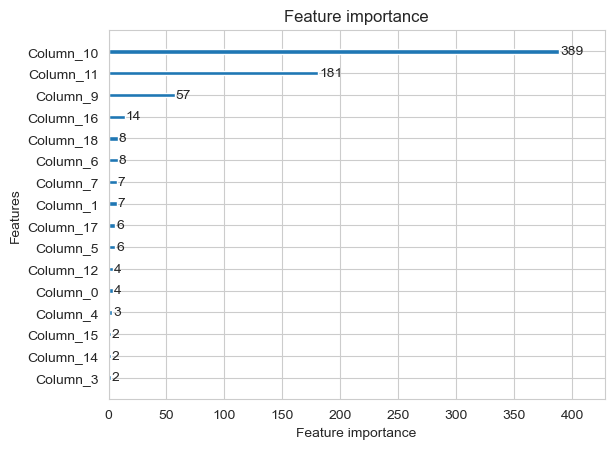

In [114]:
plt.figure(figsize=[5, 4])

plot_importance(lgbm_smt_gscv.best_estimator_.named_steps['lgbm'])

plt.show()

In [98]:
notebook_end = time.time()

print(f'Notebook Computation Time: {notebook_end - notebook_start:.2f} seconds')

Notebook Computation Time: 1559.41 seconds


### **Conclusions**<a id='conclude'></a>

The best model was LightGBM trained on SMOTE upsampled training data (AUC-ROC<sub>test</sub> = 0.81), though all the gradient boosted models performed similarly. This model additionally has a strong accuracy metric (accuracy<sub>test</sub> = 0.81), meaning the model can correctly predict the churn of 80% of customers it has not seen yet. 

#### Business Recommendations

Telecom can feel confident implementing this model to predict which customers will churn. They can expect that if the model says a customer will churn, it's very likely that that customer will indeed churn. The model may miss some customers who will churn, so it's not a bad idea to offer some additional small promotions across the clientelle. Telecom would do well to focus on keeping new customers, as old customers are likely to continue with the company.  

#### Future Research 

More research should be done on the company's newer customers to determine why they are leaving the company. Follow up surveys and additional promotions with this group could help strengthen new client retention.
